# Self-Explaining Neural Networks with Disentanglement
---

## Import libraries

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from types import SimpleNamespace
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from models.losses import *
from models.parameterizer import ConvParameterizer
from models.conceptizer import ConvConceptizer, VaeConceptizer
from models.aggregator import SumAggregator

## Configuration

In [23]:
plt.style.use('seaborn-notebook')

In [5]:
config = {"model_class": "DiSENN",
          "conceptizer": "VaeConceptizer",
          "beta": 1.0,
          "concept_loss": "BVAE_loss",
          "robustness_loss": "mnist_robustness_loss",
          "image_size": 28,
          "concept_dim": 1,
          "concept_visualization": "activation",
          "parameterizer": "ConvParameterizer",
          "cl_sizes": [1, 10, 20],
          "hidden_sizes": [320, 50],
          "num_concepts": 5,
          "num_classes": 10,
          "dropout": 0.5,
          "aggregator": "SumAggregator",
          "device": "cpu",
          "exp_name": "test_mnist_bvae",
          "dataloader": "mnist",
          "data_path": "datasets/data/mnist_data",
          "batch_size" : 16}
config = SimpleNamespace(**config)

# DiSENN
DiSENN (Self-Explaining Neural Networks with Disentanglement) is an extension of the Self-Explaining Neural Network proposed by [1]  

DiSENN incorporates a constrained variational inference framework on a 
SENN Concept Encoder to learn disentangled representations of the 
basis concepts as in [2]. The basis concepts are then independently
sensitive to single generative factors leading to better interpretability 
and lesser overlap with other basis concepts. Such a strong constraint 
better fulfills the "diversity" desiderata for basis concepts
in a Self-Explaining Neural Network.


References  
[1] Alvarez Melis, et al.
"Towards Robust Interpretability with Self-Explaining Neural Networks" NIPS 2018  
[2] Irina Higgins, et al. 
”β-VAE: Learning basic visual concepts with a constrained variational framework.” ICLR 2017. 

In [6]:
class DiSENN(nn.Module):
    """Self-Explaining Neural Network with Disentanglement """
    
    def __init__(self, vae_conceptizer, parameterizer, aggregator):
        """Instantiates the SENDD with a variational conceptizer, parameterizer and aggregator"""
        super().__init__()
        self.vae_conceptizer = vae_conceptizer
        self.parameterizer = parameterizer
        self.aggregator = aggregator

    def forward(self, x):
        """Forward pass of a DiSENN model
        
        The forward pass computes a distribution over basis concepts
        and the corresponding relevance scores. The mean concepts 
        and relevance scores are aggregated to generate a prediction.
        """
        concept_mean, concept_logvar, x_reconstruct = self.vae_conceptizer(x)
        relevances = self.parameterizer(x)
        predictions = self.aggregator(concept_mean, relevances)
        explanations = ((concept_mean, concept_logvar), relevances)
        return predictions, explanations, x_reconstruct

## Load Data

In [7]:
from datasets.dataloaders import get_dataloader
train_dl, val_dl, _ = get_dataloader(config)

## Training

In [11]:
from trainer import Trainer

In [12]:
train_config = {
  "model_class": "SENND",
  "conceptizer": "VaeConceptizer",
  "pretrain_epochs": 1,
  "beta": 1.0,
  "concept_loss": "BVAE_loss",
  "robustness_loss": "mnist_robustness_loss",
  "train": True,
  "image_size": 28,
  "concept_dim": 1,
  "concept_visualization": "activation",
  "parameterizer": "ConvParameterizer",
  "cl_sizes": [1, 10, 20],
  "hidden_sizes": [320, 50],
  "num_concepts": 5,
  "num_classes": 10,
  "dropout": 0.5,
  "aggregator": "SumAggregator",
  "device": "cpu",
  "lr": 2e-3,
  "epochs": 1,
  "robust_reg": 1e-3,
  "concept_reg": 1,
  "print_freq": 100,
  "exp_name": "test_mnist_bvae",
  "dataloader": "mnist",
  "data_path": "datasets/data/mnist_data",
  "batch_size" : 16,
  "eval_freq" : 100
}
train_config = SimpleNamespace(**train_config)

In [13]:
trainer = Trainer(train_config)
trainer.run()
trainer.finalize()

Loading data ...
Pre-training the Conceptizer... 
EPOCH:0 STEP:0 	Concept Loss: 1.241
EPOCH:0 STEP:100 	Concept Loss: 0.818
EPOCH:0 STEP:200 	Concept Loss: 0.815
EPOCH:0 STEP:300 	Concept Loss: 0.781
EPOCH:0 STEP:400 	Concept Loss: 0.845
EPOCH:0 STEP:500 	Concept Loss: 0.808
EPOCH:0 STEP:600 	Concept Loss: 0.764
EPOCH:0 STEP:700 	Concept Loss: 0.864
EPOCH:0 STEP:800 	Concept Loss: 0.746
EPOCH:0 STEP:900 	Concept Loss: 0.735
EPOCH:0 STEP:1000 	Concept Loss: 0.703
EPOCH:0 STEP:1100 	Concept Loss: 0.770
EPOCH:0 STEP:1200 	Concept Loss: 0.789
EPOCH:0 STEP:1300 	Concept Loss: 0.797
EPOCH:0 STEP:1400 	Concept Loss: 0.864
EPOCH:0 STEP:1500 	Concept Loss: 0.812
EPOCH:0 STEP:1600 	Concept Loss: 0.816
EPOCH:0 STEP:1700 	Concept Loss: 0.832
EPOCH:0 STEP:1800 	Concept Loss: 0.807
EPOCH:0 STEP:1900 	Concept Loss: 0.851
EPOCH:0 STEP:2000 	Concept Loss: 0.745
EPOCH:0 STEP:2100 	Concept Loss: 0.757
EPOCH:0 STEP:2200 	Concept Loss: 0.924
EPOCH:0 STEP:2300 	Concept Loss: 0.825
EPOCH:0 STEP:2400 	Concept

## Load Trained Model

In [14]:
conceptizer = eval(config.conceptizer)(**config.__dict__)
parameterizer = eval(config.parameterizer)(**config.__dict__)
aggregator = eval(config.aggregator)(**config.__dict__)

In [15]:
model = DiSENN(conceptizer, parameterizer, aggregator)

In [16]:
checkpoint_path = Path('../results')
model_file = checkpoint_path / config.exp_name / "checkpoints" / "best_model.pt" 
checkpoint = torch.load(model_file, config.device)
print(f"Loading trained model: {model_file}")

Loading trained model: ../results/test_mnist_bvae/checkpoints/best_model.pt


In [17]:
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

# Classification

In [18]:
xb, yb = next(iter(val_dl))
y_pred, explanations, x_reconstruct = model(xb)

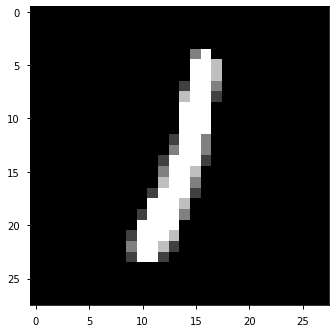

In [24]:
plt.imshow(xb[-1][0], cmap='gray')

In [25]:
y_pred.argmax(1), yb

(tensor([7, 1, 8, 1, 3, 2, 3, 6, 8, 8, 8, 4, 3, 2, 5, 6]),
 tensor([2, 0, 9, 1, 1, 2, 4, 8, 7, 6, 0, 3, 0, 7, 4, 1]))

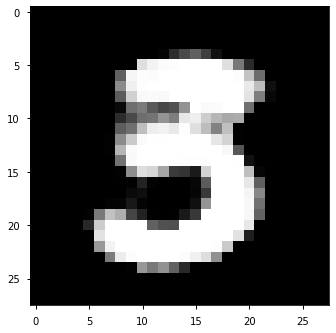

In [26]:
plt.imshow(x_reconstruct[-1][0].detach().numpy(), cmap='gray')

In [27]:
accuracy = 0.
model.eval()
with torch.no_grad():
    for i, (x, labels) in enumerate(val_dl):
        x = x.float().to(config.device)
        labels = labels.long().to(config.device)
        y_pred, explanations, x_reconstructed = model(x)
        accuracy += (y_pred.argmax(axis=1) == labels).float().mean().item()
print(f"Test Mean Accuracy: {accuracy/i*100:.3f} %")

Test Mean Accuracy: 94.552 %


# Explanation

## Generate Prototypes from Disentangled Concepts

In [28]:
num_prototypes = 10
traversal_range = 2

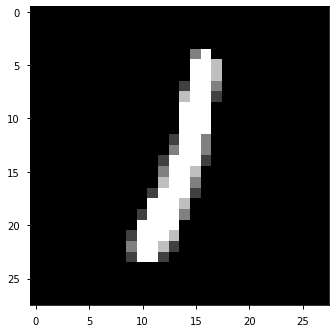

In [29]:
x = xb[-1]
plt.imshow(x.numpy().squeeze(), cmap='gray')

In [30]:
x_posterior_mean, x_posterior_logvar = model.vae_conceptizer.encoder(x)

In [31]:
concepts = x_posterior_mean.detach().numpy()
num_concepts = concepts.shape[1]
concepts_sample = model.vae_conceptizer.sample(x_posterior_mean, x_posterior_logvar).detach()

In [32]:
concepts_sample = concepts_sample.repeat(num_prototypes, 1)

In [33]:
concepts_sample

tensor([[ 0.4589, -0.1892, -0.4647, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -0.4647, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -0.4647, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -0.4647, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -0.4647, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -0.4647, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -0.4647, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -0.4647, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -0.4647, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -0.4647, -0.4256,  0.5388]])

In [34]:
def independent_traversal(matrix, dim, traversal_range=2, steps=num_prototypes):
    """Linearly traverses through one dimension of a matrix independently"""
    traversal = torch.linspace(-1 * traversal_range, traversal_range, steps)
    matrix_traversal = matrix.clone() # to avoid changing the matrix
    matrix_traversal[:, dim] = traversal
    return matrix_traversal

In [35]:
concepts_traversals = [independent_traversal(concepts_sample, dim) for dim in range(num_concepts)]

In [36]:
concepts_traversals[2]

tensor([[ 0.4589, -0.1892, -2.0000, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -1.5556, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -1.1111, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -0.6667, -0.4256,  0.5388],
        [ 0.4589, -0.1892, -0.2222, -0.4256,  0.5388],
        [ 0.4589, -0.1892,  0.2222, -0.4256,  0.5388],
        [ 0.4589, -0.1892,  0.6667, -0.4256,  0.5388],
        [ 0.4589, -0.1892,  1.1111, -0.4256,  0.5388],
        [ 0.4589, -0.1892,  1.5556, -0.4256,  0.5388],
        [ 0.4589, -0.1892,  2.0000, -0.4256,  0.5388]])

In [37]:
concepts_traversals = torch.cat(concepts_traversals, dim=0)

In [38]:
prototypes = model.vae_conceptizer.decoder(concepts_traversals)

In [39]:
prototypes.shape

torch.Size([50, 784])

In [40]:
prototype_imgs = prototypes.view((-1, 1, 28, 28))

In [41]:
prototype_imgs.shape

torch.Size([50, 1, 28, 28])

In [42]:
from torchvision.utils import make_grid

In [43]:
# nrow is number of images in a row which must be the number of prototypes
prototype_grid_img = make_grid(prototype_imgs, nrow=num_prototypes).detach().numpy()

In [44]:
prototype_grid_img.shape

(3, 152, 302)

<BarContainer object of 5 artists>

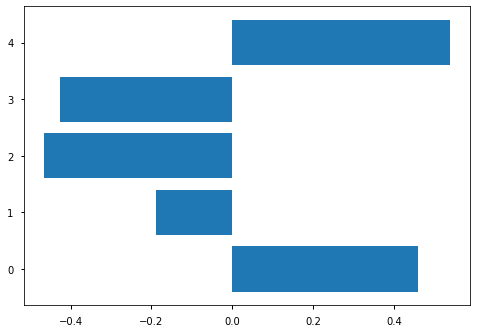

In [45]:
plt.barh(range(num_concepts), concepts.squeeze())

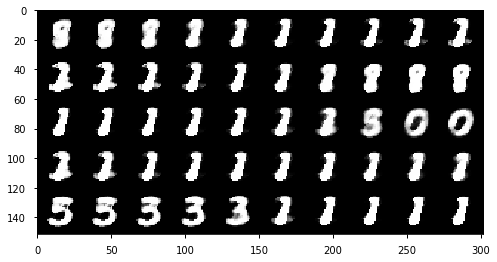

In [46]:
plt.imshow(prototype_grid_img.transpose(1,2,0))

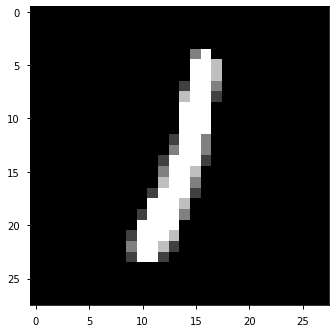

In [47]:
plt.imshow(x.numpy().squeeze(), cmap='gray')